# How to build a multi-agent network

In [16]:
import os
from dotenv import load_dotenv

load_dotenv()


from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash-preview-04-17",
    google_api_key= os.getenv("GOOGLE_API_KEY")
)

### Doing it with Handoff 

Each agent will have a corresponding node function that can conditionally return a Command object (the handoff). The node function will use an LLM with a system prompt and a tool that lets it signal when it needs to hand off to another agent. If the LLM responds with the tool calls, we will return a 

Command(goto=<other_agent>).

In [17]:
from typing_extensions import Literal

from langchain_core.tools import tool
from langgraph.graph import MessagesState, StateGraph, START
from langgraph.types import Command

# Define a helper for each of the agent nodes to call

@tool
def transfer_to_travel_advisor():
    """Ask travel advisor for help."""
    # This tool is not returning anything: we're just using it
    # as a way for LLM to signal that it needs to hand off to another agent
    return


@tool
def transfer_to_hotel_advisor():
    """Ask hotel advisor for help."""
    return


In [18]:
def travel_advisor(
    state: MessagesState,
) -> Command[Literal["hotel_advisor", "__end__"]]:
    
    system_prompt = (
        "You are the travel_advisor. You are a general travel expert that can recommend travel destinations (e.g. countries, cities, etc). "
        "If you need hotel recommendations, ask only 'hotel_advisor' for help. Don't ask the user."
    )

    messages = [{"role": "system", "content": system_prompt}] + state["messages"]


    ai_msg = llm.bind_tools([transfer_to_hotel_advisor]).invoke(messages)

    # If there are tool calls, the LLM needs to hand off to another agent

    if len(ai_msg.tool_calls) > 0:
        tool_call_id = ai_msg.tool_calls[-1]["id"]
        #it's important to insert a tool message 
        tool_msg = {
            "role": "tool",
            "content": "Successfully transferred",
            "tool_call_id": tool_call_id,
        }
        return Command(goto="hotel_advisor", update={"messages": [ai_msg, tool_msg]})

    return {"messages": [ai_msg]}


def hotel_advisor(
    state: MessagesState,
) -> Command[Literal["travel_advisor", "__end__"]]:
    system_prompt = (
        "You are the hotel_advisor. You are a hotel expert that can provide hotel recommendations for a given destination that will give a recommendation no matter what. "
        "After learning a place you must give hotel recommendations. Don't transfer if you didn't give out a name first"
    )
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    ai_msg = llm.bind_tools([transfer_to_travel_advisor]).invoke(messages)

    if len(ai_msg.tool_calls) > 0:
        tool_call_id = ai_msg.tool_calls[-1]["id"]

        tool_msg = {
            "role": "tool",
            "content": "Successfully transferred",
            "tool_call_id": tool_call_id,
        }
        
        return Command(goto="travel_advisor", update={"messages": [ai_msg, tool_msg]})

    return {"messages": [ai_msg]}

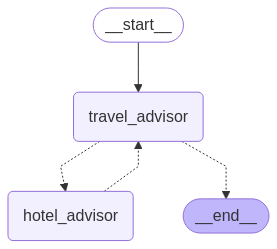

In [19]:
builder = StateGraph(MessagesState)
builder.add_node("travel_advisor", travel_advisor)
builder.add_node("hotel_advisor", hotel_advisor)

builder.add_edge(START, "travel_advisor")


graph = builder.compile()


from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

Running it

In [20]:
from langchain_core.messages import convert_to_messages


def pretty_print_messages(update):
    if isinstance(update, tuple):
        ns, update = update
        # skip parent graph updates in the printouts
        if len(ns) == 0:
            return

        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}:")
        print("\n")

    for node_name, node_update in update.items():
        print(f"Update from node {node_name}:")
        print("\n")

        for m in convert_to_messages(node_update["messages"]):
            m.pretty_print()
        print("\n")


In [21]:
for chunk in graph.stream(
    {
        "messages": [
            (
                "user",
                "i wanna go somewhere warm in the caribbean. pick one destination and give me hotel recommendations",
            )
        ]
    }, 
):
    pretty_print_messages(chunk)


Update from node travel_advisor:


================================== Ai Message ==================================

Okay, I can help you with finding a warm destination in the Caribbean. To give you the best hotel recommendations for that destination, I need to connect you with the hotel advisor who specializes in that.

I will transfer you now.
Tool Calls:
  transfer_to_hotel_advisor (dc36e841-1087-4f72-a3fd-de77bb71a0a1)
 Call ID: dc36e841-1087-4f72-a3fd-de77bb71a0a1
  Args:
================================= Tool Message =================================

Successfully transferred


Update from node hotel_advisor:


================================== Ai Message ==================================

I've passed your request to a travel advisor. They can help you choose a warm Caribbean destination and find hotels there.




### Using React Agent

Start with few tools for agents

In [22]:
import random
from typing_extensions import Literal


@tool
def get_travel_recommendations():
    """Get recommendation for travel destinations"""
    return random.choice(["aruba", "turks and caicos"])


@tool
def get_hotel_recommendations(location: Literal["aruba", "turks and caicos"]):
    """Get hotel recommendations for a given destination."""
    return {
        "aruba": [
            "The Ritz-Carlton, Aruba (Palm Beach)"
            "Bucuti & Tara Beach Resort (Eagle Beach)"
        ],
        "turks and caicos": ["Grace Bay Club", "COMO Parrot Cay"],
    }[location]


Handoff Tool

In [23]:
from typing import Annotated

from langchain_core.tools.base import InjectedToolCallId
from langgraph.prebuilt import InjectedState


def make_handoff_tool(*, agent_name: str):
    """Create a tool that can return handoff via a Command"""
    tool_name = f"transfer_to_{agent_name}"

    @tool(tool_name)
    def handoff_to_agent(
        state: Annotated[dict, InjectedState],
        tool_call_id: Annotated[str, InjectedToolCallId],
    ):
        """Ask another agent for help."""
        tool_message = {
            "role": "tool",
            "content": f"Successfully transferred to {agent_name}",
            "name": tool_name,
            "tool_call_id": tool_call_id,
        }
        return Command(
            # navigate to another agent node 
            goto=agent_name,
            graph=Command.PARENT,
            # This is the state update that the agent `agent_name` will see when it is invoked.
            # We're passing agent's FULL internal message history AND adding a tool message to make sure
            # the resulting chat history is valid.
            update={"messages": state["messages"] + [tool_message]},
        )

    return handoff_to_agent

In [24]:
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.prebuilt import create_react_agent
from langgraph.types import Command


# Define travel advisor ReAct agent
travel_advisor_tools = [
    get_travel_recommendations,
    make_handoff_tool(agent_name="hotel_advisor"),
]

travel_advisor = create_react_agent(
    llm,
    travel_advisor_tools,
    prompt=(
        "You are a general travel expert that can recommend travel destinations (e.g. countries, cities, etc). "
        "If you need hotel recommendations, ask 'hotel_advisor' for help. "
        "You MUST include human-readable response before transferring to another agent."
    ),
)


def call_travel_advisor(
    state: MessagesState,
) -> Command[Literal["hotel_advisor", "__end__"]]:
    # You can also add additional logic like changing the input to the agent / output from the agent, etc.
    # NOTE: we're invoking the ReAct agent with the full history of messages in the state
    return travel_advisor.invoke(state)


# Define hotel advisor ReAct agent
hotel_advisor_tools = [
    get_hotel_recommendations,
    make_handoff_tool(agent_name="travel_advisor"),
]

hotel_advisor = create_react_agent(
    llm,
    hotel_advisor_tools,
    prompt=(
        "You are a hotel expert that can provide hotel recommendations for a given destination. "
        "If you need help picking travel destinations, ask 'travel_advisor' for help."
        "You MUST include human-readable response before transferring to another agent."
    ),
)


def call_hotel_advisor(
    state: MessagesState,
) -> Command[Literal["travel_advisor", "__end__"]]:
    return hotel_advisor.invoke(state)

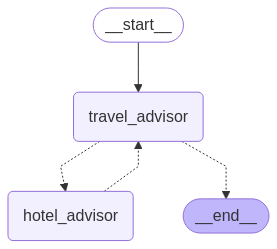

In [25]:
builder = StateGraph(MessagesState)
builder.add_node("travel_advisor", call_travel_advisor)
builder.add_node("hotel_advisor", call_hotel_advisor)
# we'll always start with a general travel advisor
builder.add_edge(START, "travel_advisor")

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))


In [30]:
for chunk in graph.stream(
    {
        "messages": [
            (
                "user",
                "i wanna go somewhere warm in the caribbean. pick for me one destination and pick me a hotel recommendations",
            )
        ]
    },
    subgraphs=True,
):
    pretty_print_messages(chunk)


Update from subgraph travel_advisor:


Update from node agent:


================================== Ai Message ==================================

Okay, I can help you with that! For a warm getaway in the Caribbean, I recommend Barbados. It's known for its beautiful beaches, vibrant culture, and warm climate.

Now that we have a destination, I will transfer you to our hotel advisor who can help you find the perfect place to stay in Barbados.
Tool Calls:
  transfer_to_hotel_advisor (7625ff16-a7d0-4843-8e06-b02fde647280)
 Call ID: 7625ff16-a7d0-4843-8e06-b02fde647280
  Args:


Update from subgraph hotel_advisor:


Update from node agent:


================================== Ai Message ==================================

I can help you with finding a great hotel in the Caribbean! However, you first need to choose a specific destination.

I can transfer you to a travel advisor who can help you pick a destination in the Caribbean. Would you like me to do that?




to continue the conversation do another stream

### Doing it with a supervisor

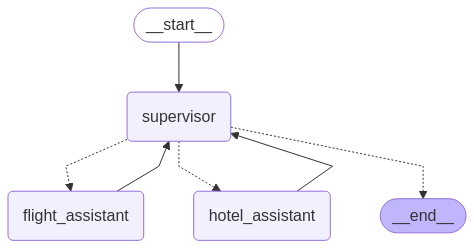

In [31]:
from langgraph.prebuilt import create_react_agent
from langgraph_supervisor import create_supervisor

def book_hotel(hotel_name: str):
    """Book a hotel"""
    return f"Successfully booked a stay at {hotel_name}."

def book_flight(from_airport: str, to_airport: str):
    """Book a flight"""
    return f"Successfully booked a flight from {from_airport} to {to_airport}."

flight_assistant = create_react_agent(
    llm,
    tools=[book_flight],
    prompt="You are a flight booking assistant. Don't ask questions! Only book by calling the book_flight tool. Don't give attention to hotels",
    name="flight_assistant"
)

hotel_assistant = create_react_agent(
    llm,
    tools=[book_hotel],
    prompt="You are a hotel booking assistant. Only care about booking a hotel. Don't ask questions!Only book by calling the book_hotel tool",
    name="hotel_assistant"
)


supervisor = create_supervisor(
    agents=[flight_assistant, hotel_assistant],
    model=llm,
    prompt=(
        "You manage a hotel booking assistant and a"
        "flight booking assistant. Assign work to them without asking the user."
    )
).compile()


display(Image(supervisor.get_graph().draw_mermaid_png()))



In [33]:
for chunk in supervisor.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "book a flight from BOS to JFK and a stay at McKittrick Hotel"
            }
        ]
    }, 
    subgraphs=True,
):
    pretty_print_messages(chunk)

Update from subgraph supervisor:


Update from node agent:


================================== Ai Message ==================================
Name: supervisor
Tool Calls:
  transfer_to_flight_assistant (c1f2bbd0-e7df-4d53-a541-fdfc84fc24f2)
 Call ID: c1f2bbd0-e7df-4d53-a541-fdfc84fc24f2
  Args:


Update from subgraph flight_assistant:


Update from node agent:


================================== Ai Message ==================================
Name: flight_assistant

OK. I'll book your flight from BOS to JFK.
Tool Calls:
  book_flight (2a529e11-dfbd-4260-8fda-7bb85b89a653)
 Call ID: 2a529e11-dfbd-4260-8fda-7bb85b89a653
  Args:
    from_airport: BOS
    to_airport: JFK


Update from subgraph flight_assistant:


Update from node tools:


================================= Tool Message =================================
Name: book_flight

Successfully booked a flight from BOS to JFK.


Update from subgraph flight_assistant:


Update from node agent:


================================== Ai Mes